<h1> Import Libraries

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import albumentations as A
from albumentations.pytorch import ToTensorV2
import joblib

<h1> Inisialisasi Face Detector + ArcFace Model

In [2]:
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\DELL/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\DELL/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\DELL/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\DELL/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\DELL/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

<h1> Load Dataset & Ekstrak Embedding

In [3]:
dataset_path = '../dataset'  # sesuaikan jika berbeda
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print("Kelas yang ditemukan:", classes)

Kelas yang ditemukan: ['aisyah', 'asyam', 'ucup']


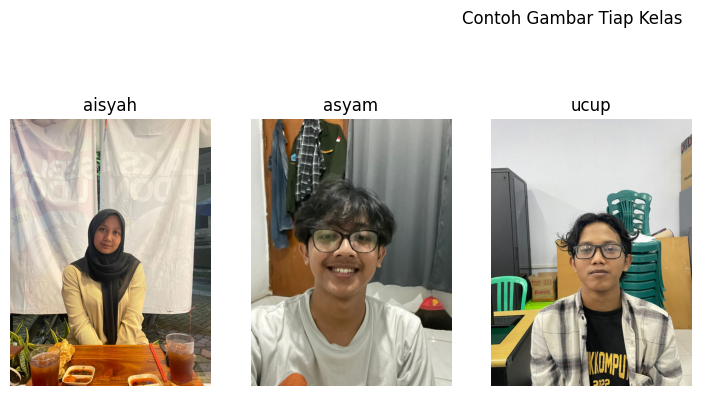

In [4]:
# 4. TAMPILKAN CONTOH GAMBAR DARI SETIAP KELAS
n_show = 1
plt.figure(figsize=(15, 5))
for idx, cls in enumerate(classes[:5]):
    img_files = os.listdir(os.path.join(dataset_path, cls))
    img = cv2.imread(os.path.join(dataset_path, cls, img_files[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, idx+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Contoh Gambar Tiap Kelas')
plt.show()

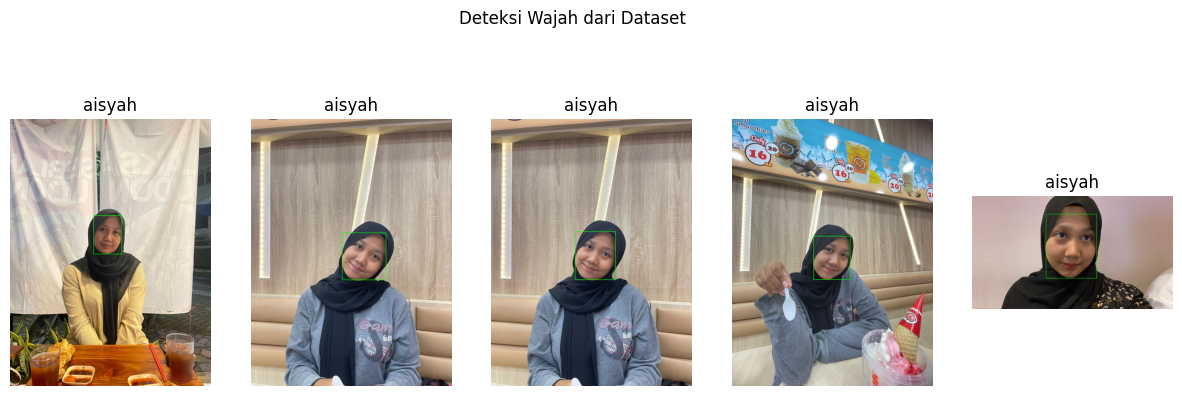

In [5]:
# 5. TAMPILKAN HASIL DETEKSI WAJAH UNTUK BEBERAPA GAMBAR
plt.figure(figsize=(15, 5))
count = 0
for person_name in classes:
    person_dir = os.path.join(dataset_path, person_name)
    for img_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        faces = app.get(img)
        if len(faces) > 0:
            b = faces[0].bbox.astype(int)
            img = cv2.rectangle(img.copy(), (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, count+1)
            plt.imshow(img)
            plt.title(person_name)
            plt.axis('off')
            count += 1
        if count >= 5:
            break
    if count >= 5:
        break
plt.suptitle("Deteksi Wajah dari Dataset")
plt.show()

<h1>Ekstraksi Embedding

Processing classes with augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

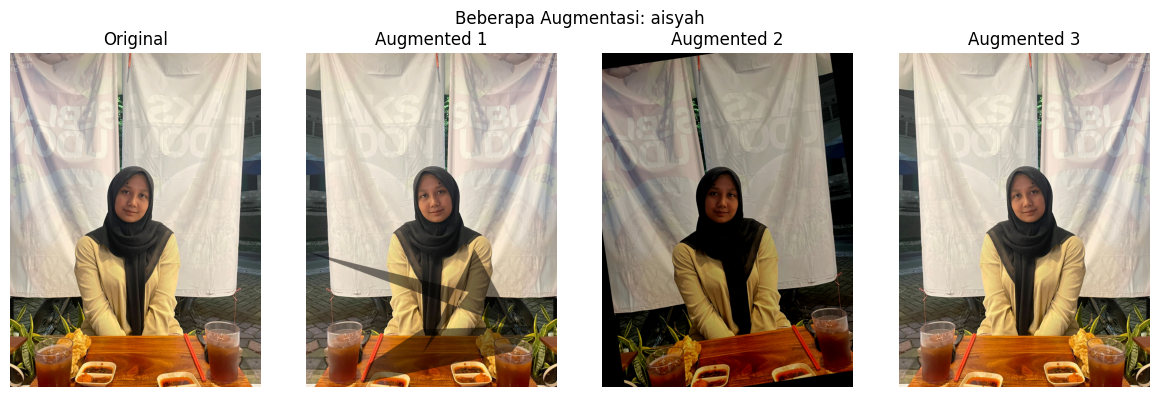

Processing classes with augmentation:  33%|███▎      | 1/3 [00:22<00:45, 22.97s/it]

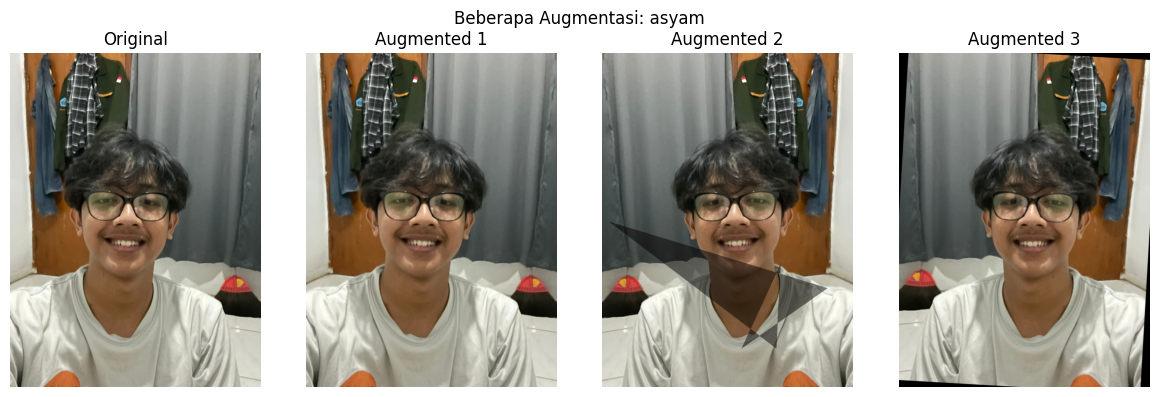

Processing classes with augmentation:  67%|██████▋   | 2/3 [00:54<00:28, 28.20s/it]

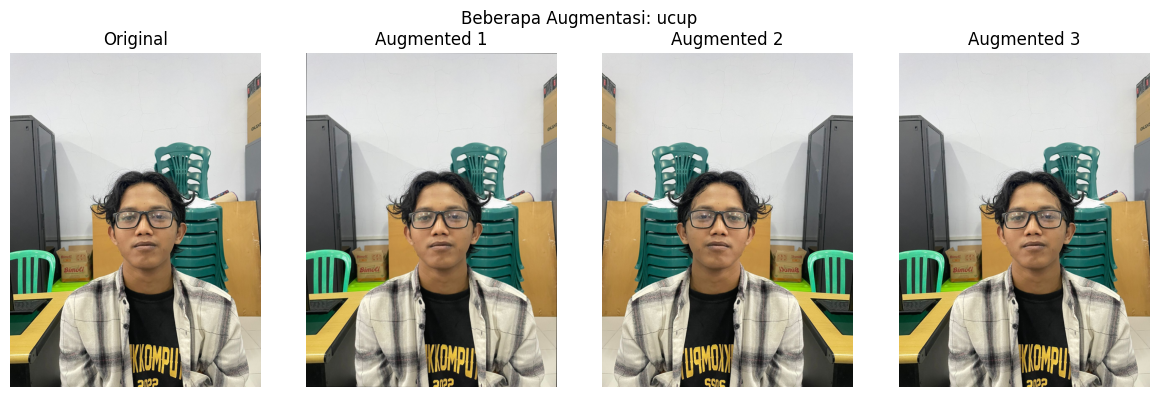

Processing classes with augmentation: 100%|██████████| 3/3 [01:26<00:00, 28.81s/it]

Total embeddings: 76


In [6]:
# 6. EKSTRAKSI EMBEDDING (ASLI + AUGMENTED)
embeddings = []
labels = []

# Definisikan augmentasi
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.RandomShadow(p=0.2)
])

for person_name in tqdm(classes, desc="Processing classes with augmentation"):
    person_dir = os.path.join(dataset_path, person_name)
    img_names = os.listdir(person_dir)

    for img_name in img_names:
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = app.get(img_rgb)
        if len(faces) > 0:
            face = faces[0]
            embeddings.append(face.embedding)
            labels.append(person_name)

        # Lakukan augmentasi
        aug = transform(image=img)
        aug_img = aug['image']
        aug_rgb = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

        # Tampilkan beberapa variasi augmentasi untuk 1 gambar
        if img_name == img_names[0]:  # hanya 1 gambar per kelas
            plt.figure(figsize=(12, 4))
            
            # Tampilkan original
            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Original")
            plt.axis('off')
            
            # Tampilkan 3 hasil augmentasi
            for i in range(3):
                aug_i = transform(image=img)
                aug_img_i = aug_i['image']
                aug_rgb_i = cv2.cvtColor(aug_img_i, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 4, i+2)
                plt.imshow(aug_rgb_i)
                plt.title(f"Augmented {i+1}")
                plt.axis('off')
            
            plt.suptitle(f"Beberapa Augmentasi: {person_name}")
            plt.tight_layout()
            plt.show()

        # Ekstrak embedding dari augmentasi jika wajah terdeteksi
        aug_faces = app.get(aug_rgb)
        if len(aug_faces) > 0:
            aug_face = aug_faces[0]
            embeddings.append(aug_face.embedding)
            labels.append(person_name)

print(f"Total embeddings: {len(embeddings)}")

<h1> Encode Label

In [7]:
# 7. ENKODE LABEL
le = LabelEncoder()
labels_enc = le.fit_transform(labels)

<h1> Split Data

In [8]:
# 8. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
)

<h1> Train Classifier (SVM)

In [9]:
# 9. TRAINING SVM CLASSIFIER
print("Training SVM...")
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)
print("Training selesai.")

Training SVM...
Training selesai.


<h1>Evaluasi

In [10]:
# 10. PREDIKSI & EVALUASI
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Akurasi: {acc:.2f}")
print("\n📋 Classification Report:\n", classification_report(
    y_test, y_pred, target_names=le.inverse_transform(sorted(set(y_test)))
))


🎯 Akurasi: 1.00

📋 Classification Report:
               precision    recall  f1-score   support

      aisyah       1.00      1.00      1.00         5
       asyam       1.00      1.00      1.00         6
        ucup       1.00      1.00      1.00         5

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



<h1> Confusion Matrix

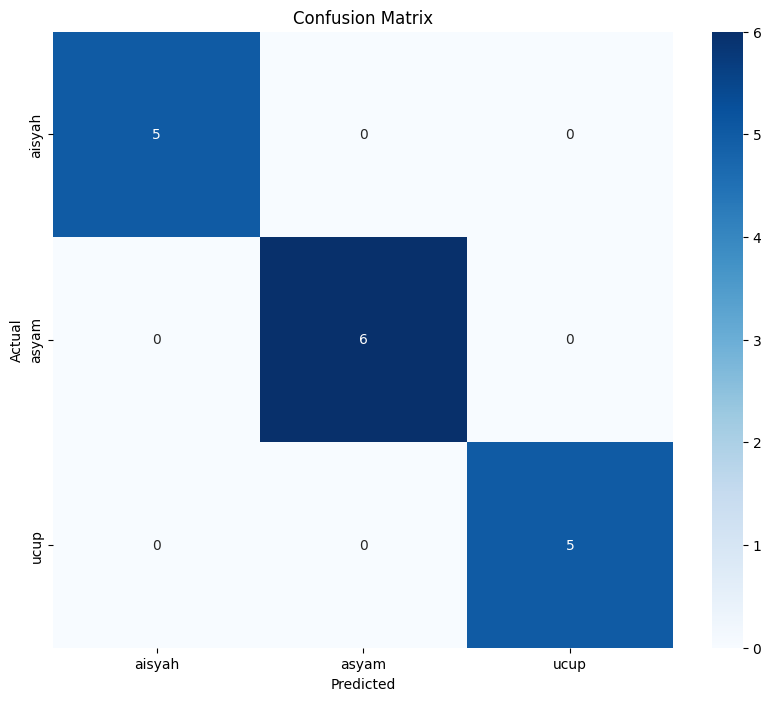

In [11]:
# 11. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.inverse_transform(sorted(set(y_test))),
            yticklabels=le.inverse_transform(sorted(set(y_test))),
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<h1> Save Model dan Label Encoder

In [14]:
joblib.dump(clf, 'model_face_recognizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

<h1> Prediksi Gambar Baru (Testing)

In [15]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    faces = app.get(img)
    if len(faces) == 0:
        return "No face detected"
    
    face = faces[0]
    emb = face.embedding.reshape(1, -1)
    
    pred = clf.predict(emb)
    prob = clf.predict_proba(emb).max()
    label = le.inverse_transform(pred)[0]
    
    return f"{label} (confidence: {prob:.2f})"

In [16]:
test_img_path = '../test_images/asyammm.jpg'
print(predict_image(test_img_path))

asyam (confidence: 0.87)
